<h1 align="center">Markov Chain Monte Carlo for fun and profit</h1>
<h1 align="center"> 🎲 ⛓️ 👉 🧪 </h1>

# Introduction

Hello and welcome to the documentation for MCMCFF! These notebooks will guide you through the process of writing a medium sized scientific software project, discussing the decision and tradeoffs made along the way.

## Setting up your environment

It's strongly encouraged that you follow along this notebook in an enviroment where you can run the cells yourself and change them. You can either clone this git repository and run the cells in a python environment on your local machine, or if you for some reason can't do that (because you're an a phone or tablet for instance) you can instead open this notebook in [binder](link)

I would also suggest you setup a python environment just for this. You can use your preferred method to do this, but I will recomend `conda` because it's both what I currently use and what is recommeded by Imperial: LINK 

```bash
#make a new conda environment named recode, with python 3.9 and the packages in requirements.txt
conda env create --name recode  python=3.9 --file requirements.txt

#activate the environment
conda activate recode
```

## The Problem

So without further ado lets talk about the problem we'll be working on, you don't necessaryily need to understand the full details of this to learn the important lessons but I will give a quick summary here. We want to simulate a physical model called the **Ising model**, which is famous in physics because it's about the simplest thing you can come up with that displays a phase transition, a special kind of shift between two different behaviours.

I'm going to weave exposition and code here so don't mind if I just take a moment to impor some packages and do some housekeeping:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# This loads some custom styles for matplotlib
import json, matplotlib

with open("assets/matplotlibrc.json") as f:
    matplotlib.rcParams.update(json.load(f))

np.random.seed(
    42
)  # This makes our random numbers reproducable when the notebook is rerun in order

We're going to be working with arrays of numbers so it will make sense to work with `Numpy` and we'll also want to plot things, the standard choice for this is `matplotlib`, though there are other options, `pandas` and `plotly` being notable ones.

Let me quickly plot something to aid the imagination:

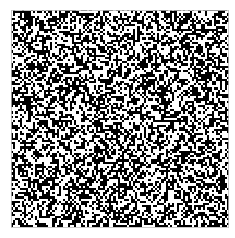

In [2]:
state = np.random.choice([-1, 1], size=(100, 100))


def show_state(state, ax=None):
    if ax is None:
        f, ax = plt.subplots()
    ax.matshow(state, cmap="Greys", vmin=-1, vmax=1)
    ax.set(xticks=[], yticks=[])


show_state(state)

In my head, the Ising model is basically all about peer pressure. You're a tiny creature and you live in a little world where you can only be one of two things, up/down, left/right, in/out doesn't matter. 

But what *does matter* is that you're doing the same thing as you're neighbours. We're going to visualise this with images like the above, representing the two different camps, though at the moment what I've plotted is random, there's no peer pressure going on yet.

The way that a physicist would quantify this peer pressure is to assign a number to each state, lower numbers meaning more of the little creatures are doing the same thing as their neighbours. We'll call this the Energy, because physicists always call things Energy, that's just what we do.

To calculate the energy what we're gonna do is look at all the pixels/creatures, and for each one, we look at the four neighbours to the N/E/S/W, everytime we find a neighbour that agrees, we'll subtract 1 from our total and every time we find neighbours that disagree we'll add 1 to our total. Creatures at the edges will simply have fewer neighbours to worry about. 

I'll show you what the equation for this looks like, but don't worry to much about it, the word description should be enough to write some code. If we assign the ith creature the label $s_i = \pm1$ then the energy is 
$$E = \sum_{(i,j)} s_i s_j$$

Ok let's do some little tests, let's make the all up, all down and random state and see if we can compute their energies.

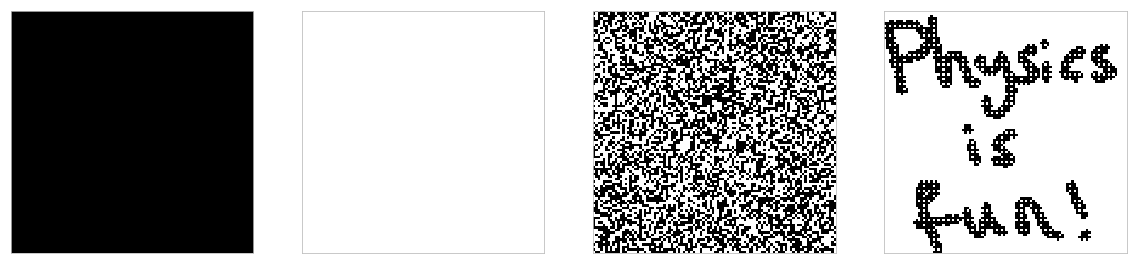

In [3]:
all_up = np.ones([100, 100])
all_down = -np.ones([100, 100])
random = np.random.choice([-1, 1], size=(100, 100))

from matplotlib.image import imread

custom = (
    1 - 2 * imread("data/test_state.png")[:, :, 0]
)  # load a 100x100 png, take the red channel, remap 0,1 to -1,1

states = [all_up, all_down, random, custom]

f, axes = plt.subplots(ncols=4, figsize=(20, 5))
for ax, state in zip(axes, states):
    show_state(state, ax=ax)

If you stare at the first two long enough you'll realise we can figure out the energy of all_up and all_down without writing any code at all:

<div style="margin:auto;max-width:800px;">
<img src="assets/energy_diagram.png"/>
</div>

So we know that for the first two:
$$E = \frac{1}{L^2} (4(L-2)^2 + 12(L-2) + 8)$$

And for the random case we can make a pretty good guess that it should be zero on average. And the last we will just use to as a testcase.

In [4]:
def E_prediction_all_the_same(L):
    return -(4 * (L - 2) ** 2 + 12 * (L - 2) + 8)


L = 100
print(f"For L = {L}, We predict E = {E_prediction_all_the_same(L)}")

For L = 100, We predict E = -39600


## Exercise 1: Write a function to compute the energy of a state

See if you can write a function that calculates the energy and reproduces all the above cases. 

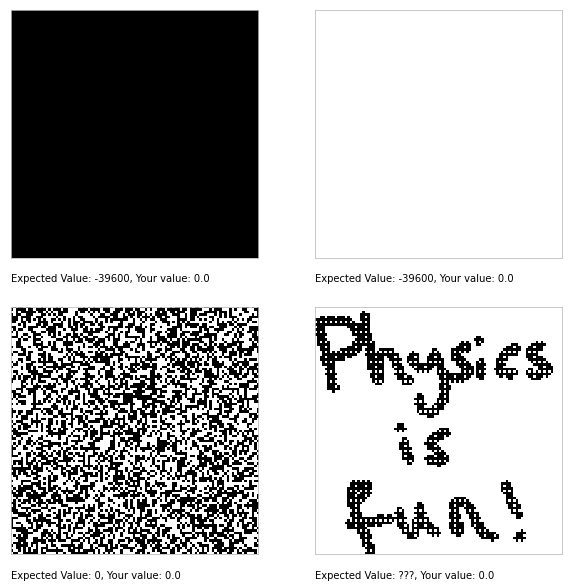

In [5]:
# you are welcome to solve this in any way you like, I've just filled out a very simple way to do it
def energy(state):
    E = 0
    N, M = state.shape
    for i in range(N):
        for k in range(M):
            # your code goes here
            pass
    return E / (N * M)


expected_values = [
    E_prediction_all_the_same(100),
    E_prediction_all_the_same(100),
    0,
    "???",
]

f, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
axes = axes.flatten()
for ax, state, exp_value in zip(axes, states, expected_values):
    show_state(state, ax=ax)
    ax.text(
        0,
        -0.1,
        f"Expected Value: {exp_value}, Your value: {energy(state)}",
        transform=ax.transAxes,
    )

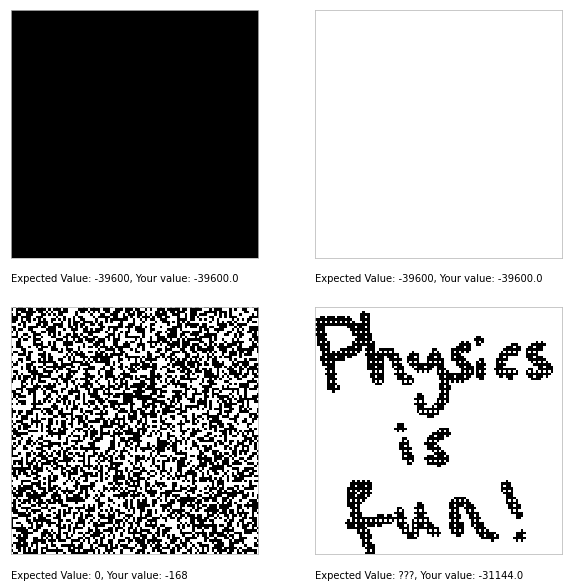

In [6]:
## Solution


def energy(state):
    E = 0
    N, M = state.shape
    for i in range(N):
        for j in range(M):
            # handle the north and south neighbours
            for di in [1, -1]:
                if 0 <= (i + di) < N:
                    E -= state[i, j] * state[i + di, j]

            # handle the east and west neighbours
            for dj in [1, -1]:
                if 0 <= (j + dj) < M:
                    E -= state[i, j] * state[i, j + dj]

    return E


expected_values = [
    E_prediction_all_the_same(100),
    E_prediction_all_the_same(100),
    0,
    "???",
]

f, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
axes = axes.flatten()
for ax, state, exp_value in zip(axes, states, expected_values):
    show_state(state, ax=ax)
    ax.text(
        0,
        -0.1,
        f"Expected Value: {exp_value}, Your value: {energy(state)}",
        transform=ax.transAxes,
    )

It's a bit tricky to know what to do with the random value, let's try running it 100 times and see what we get:

mean = -0.24, standard error = 29.819071481184658


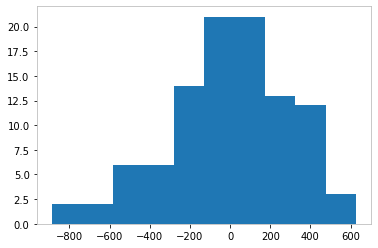

In [7]:
L = 100  # How large the system should be
N = 100  # How many random samples to use
energies = [energy(np.random.choice([-1, 1], size=(L, L))) for _ in range(N)]
plt.hist(energies)
print(f"mean = {np.mean(energies)}, standard error = {np.std(energies) / np.sqrt(N)}")

If you run this a few times you'll see the mean is usually within a few standard errors of 0, which gives us some confidence. In the testing section we will discuss how we might go about doing automated tests of random variables like this. 

### Making it a little faster

This project is not intended to focus on optimising for performance but it is worth putting a little effort into making this function faster so that we can run experiments more quickly later.

The main thing that slows us down here is that we've written a 'tight loop' in pure python, the energy function is just a loop over the fundamental operation:
```python
E -= state[i,j] * state[i+di, j]
```
which in theoy only requires a few memory load operations, a multiply, an add and a store back to memory (give or take). However because Python is such a dynamic language, it will have to do extra things like check the type and methods of `state` and `E`, invoke their array access methods `object.__get__`, etc etc. We call this extra work overhead.

In most cases the ratio of overhead to actual computation is not too bad, but here because the fundamental computation is so simple it's likely the overhead accounts for much more of the overal time.

In scientific python like this there are usually two main options for reducing the overhead:

#### Using Arrays
One way is we work with arrays of numbers and operations defined over those arrays such as `sum`, `product` etc. `Numpy` is the canonical example of this in Python but many machine learning libraries are essentually doing a similar thing. We rely on the library to implement the operations efficiently and try to chain those operations together to achieve what we want. This imposes some limitations on the way we can write our code.

#### Using Compilation
The alternative is that we convert our Python code into a more efficient form that incurs less overhead. This requires a compilation or transpilation step and imposes a different set of constraints on the code.

It's a little tricky to decide which of the two approaches will work best for a given problem. My advice would be to have some familiarity with both but ultimatly to use what makes your development experience the best, since you'll likely spend more time writing the code than you will waiting for it to run!

## Exercise 2: Write a faster version of `energy(state)`

You can use `numpy`, `numba`, `cython`, or anything else, by what factor can you beat the naive approach? Numba is probably the easiest here.

In [8]:
def test_energy_function(energy_function):
    assert np.all(energy_function(state) == energy(state) for state in states)


def time_energy_function(energy_function):
    return [energy_function(state) for state in states]


def your_faster_energy_function(state):
    return energy(
        state
    )  # <-- replace this with your implementation and compare how fast it runs!


print("Naive baseline implementation")
test_energy_function(
    energy
)  # this should always pass because it's just comparing to itself!
naive = %timeit -o -n 10 time_energy_function(energy)

print("\nYour version")
test_energy_function(your_faster_energy_function)
yours = %timeit -o -n 10 time_energy_function(your_faster_energy_function)
print(f"Your speedup: {naive.best/yours.best :.0f}x !")

Naive baseline implementation
78.1 ms ± 997 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Your version
75.6 ms ± 2.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Your speedup: 1x !


## Solution 2

In [9]:
def test_energy_function(energy_function):
    return [energy_function(state) for state in states]


from numba import jit


@jit(nopython=True)
def numba_energy(state):
    E = 0
    N, M = state.shape
    for i in range(N):
        for j in range(M):
            # handle the north and south neighbours
            for di in [1, -1]:
                if 0 <= (i + di) < N:
                    E -= state[i, j] * state[i + di, j]

            # handle the east and west neighbours
            for dj in [1, -1]:
                if 0 <= (j + dj) < M:
                    E -= state[i, j] * state[i, j + dj]

    return E


def numpy_energy(state):
    E = -np.sum(state[:-1, :] * state[1:, :]) - np.sum(state[:, :-1] * state[:, 1:])
    return 2 * E


print("Naive baseline implementation")
naive = %timeit -o -n 10 time_energy_function(energy)

print("\nNumba version")
test_energy_function(numba_energy)
numba = %timeit -n 10 -o time_energy_function(numba_energy)
print(f"Numba Speedup: {naive.best/numba.best :.0f}x !")

print("\nNumpy version")
test_energy_function(numpy_energy)
numpy = %timeit -n 10 -o time_energy_function(numpy_energy)
print(f"Numpy Speedup: {naive.best/numpy.best :.0f}x !")

Naive baseline implementation
77.1 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Numba version
205 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Numba Speedup: 417x !

Numpy version
167 µs ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Numpy Speedup: 554x !


While writing the above faster versions I realised two things, first there was a bug in my code! I had written 
```python
for dj in [1,-1]:
    if 0 <= (j + dj) < M:
        E -= state[i,j] * state[i+di, j]
```
where I of course meant to have:
```python
for dj in [1,-1]:
    if 0 <= (j + dj) < M:
        E -= state[i,j] * state[i, j+dj]
```
I found this while writing the numpy version because the two functions were not giving the same results, I didn't pick it up from writing the numba code because as you can see I just copied the implementation over. So the first lesson is that simple test cases don't always catch even relatively obvious bugs. 

The second thing was that even my naive function was doing more work than it needed to! Because if the symmetry of how two neighbours talks to each other, we can rewrite the code as:

In [10]:
def energy2(state):
    E = 0
    N, M = state.shape
    for i in range(N):
        for j in range(M):
            # handle the north and south neighbours
            if 0 <= (i + 1) < N:
                E -= state[i, j] * state[i + 1, j]

            # handle the east and west neighbours
            if 0 <= (j + 1) < M:
                E -= state[i, j] * state[i, j + 1]

    return 2 * E


print("\nImproved Naive version")
energy2(states[0])  # run the function once to let numba compile it before timing it
e2 = %timeit -o test_energy_function(energy2)
print(f"Speedup: {naive.best/e2.best :.0f}x !")


Improved Naive version
32.3 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Speedup: 2x !


## Conclusion
So far we've discussed the problem we want to solve, written a little code, tested it a bit and made some speed improvements.

In the next notebook we will package the code up into a little python package, this is has two big benefits to use: 
1. I won't have to redefine the energy function we just wrote in the next notebook 
1. It will help with testing and documenting our code later